# **Skin Diseases Recognition**

## Import and Install Requirements

In [ ]:
!pip install split-folders tqdm

In [ ]:
import os
import numpy as np
from google.colab import drive, files
import splitfolders
import matplotlib
import matplotlib.pyplot as plt
import itertools
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam
import keras
from keras.preprocessing import image
import sklearn
from sklearn.metrics import confusion_matrix

In [ ]:
!python --version
print('Tensorflow {}'.format(tf.__version__))
print('Numpy {}'.format(np.__version__))
print('Matplotlib {}'.format(matplotlib.__version__))
print('Splitfolder {}'.format(splitfolders.__version__))
print('Keras {}'.format(keras.__version__))
print('Scikit-learn {}'.format(sklearn.__version__))

Python 3.7.10
Tensorflow 2.5.0
Numpy 1.19.5
Matplotlib 3.2.2
Splitfolder 0.4.3
Keras 2.5.0
Scikit-learn 0.22.2.post1


## Import and Split Data

Import data from google drive :

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls '/content/gdrive/Shareddrives/bangkit/Skin Diseases'

'Atopic dermatitis'  'Drool rash'   Impetigo	 Rubeola
'Cradle cap'	      Hemangioma    Miliaria	 Varicella
'Diaper rash'	      HFMD	    Pityriasis


Total images in each diseases:

In [ ]:
print('Atopic dermatitis: {}'.format(len(os.listdir('/content/gdrive/Shareddrives/bangkit/Skin Diseases/Atopic dermatitis'))))
print('Cradle cap: {}'.format(len(os.listdir('/content/gdrive/Shareddrives/bangkit/Skin Diseases/Cradle cap'))))
print('Diaper rash: {}'.format(len(os.listdir('/content/gdrive/Shareddrives/bangkit/Skin Diseases/Diaper rash'))))
print('Drool Rush: {}'.format(len(os.listdir('/content/gdrive/Shareddrives/bangkit/Skin Diseases/Drool rash'))))
print('HFMD: {}'.format(len(os.listdir('/content/gdrive/Shareddrives/bangkit/Skin Diseases/HFMD'))))
print('Hemangioma: {}'.format(len(os.listdir('/content/gdrive/Shareddrives/bangkit/Skin Diseases/Hemangioma'))))
print('Impetigo: {}'.format(len(os.listdir('/content/gdrive/Shareddrives/bangkit/Skin Diseases/Impetigo'))))
print('Miliraia: {}'.format(len(os.listdir('/content/gdrive/Shareddrives/bangkit/Skin Diseases/Miliaria'))))
print('Pityriasis: {}'.format(len(os.listdir('/content/gdrive/Shareddrives/bangkit/Skin Diseases/Pityriasis'))))
print('Rubeola: {}'.format(len(os.listdir('/content/gdrive/Shareddrives/bangkit/Skin Diseases/Rubeola'))))
print('Varicella: {}'.format(len(os.listdir('/content/gdrive/Shareddrives/bangkit/Skin Diseases/Varicella'))))

Atopic dermatitis: 108
Cradle cap: 85
Diaper rash: 83
Drool Rush: 65
HFMD: 75
Hemangioma: 93
Impetigo: 117
Miliraia: 100
Pityriasis: 117
Rubeola: 66
Varicella: 70


Split data into training data (80%), validation data (10%) and testing data (10%) :

In [ ]:
!mkdir skin_dataset
splitfolders.ratio("/content/gdrive/Shareddrives/bangkit/Skin Diseases", output="skin_dataset",seed=42, ratio=(.8,.1,.1), group_prefix=None)

Copying files: 979 files [07:25,  2.20 files/s]


Some sample images on training data :

Found 780 files belonging to 11 classes.


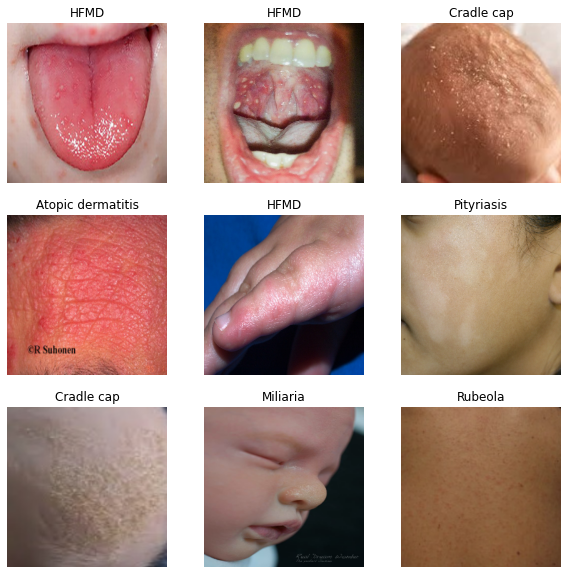

In [ ]:
train_dataset = image_dataset_from_directory('/content/skin_dataset/train', shuffle=True)

class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## MobileNet Model for Transfer Learning

In [ ]:
mobile = tf.keras.applications.mobilenet.MobileNet(input_tensor = tf.keras.Input(shape=(224,224,3)))

17227776/17225924 [==============================] - 0s 0us/step


In [ ]:
x = mobile.layers[-6].output
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
output = tf.keras.layers.Dense(11, activation='softmax')(x)

model = Model(inputs=mobile.input, outputs=output)
for layer in model.layers[:-13]:
  layer.trainable = False

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0   

## Image Data Generator

In [ ]:
train_dir = '/content/skin_dataset/train'
validation_dir = '/content/skin_dataset/val'

train_datagen = ImageDataGenerator(rescale=1/255.0,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.4,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224,224),
                                                    batch_size=20,
                                                    class_mode = 'categorical')  


test_datagen = ImageDataGenerator(rescale=1/255.0)

validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         target_size=(224,224),
                                                         batch_size=20,
                                                         class_mode = 'categorical')

Found 780 images belonging to 11 classes.
Found 93 images belonging to 11 classes.


## Training Model

In [ ]:
model.compile(optimizer = Adam(learning_rate=0.00002),
  loss='categorical_crossentropy',
  metrics=['accuracy'])

history = model.fit(train_generator,
                            epochs=100,
                            validation_data=validation_generator)

Epoch 1/100
39/39 [==============================] - 12s 268ms/step - loss: 2.3578 - accuracy: 0.1462 - val_loss: 2.2171 - val_accuracy: 0.1828
Epoch 2/100
39/39 [==============================] - 10s 260ms/step - loss: 2.0959 - accuracy: 0.2859 - val_loss: 2.0040 - val_accuracy: 0.3226
Epoch 3/100
39/39 [==============================] - 10s 257ms/step - loss: 1.8801 - accuracy: 0.4179 - val_loss: 1.7843 - val_accuracy: 0.4516
Epoch 4/100
39/39 [==============================] - 10s 259ms/step - loss: 1.6738 - accuracy: 0.5282 - val_loss: 1.5949 - val_accuracy: 0.5161
Epoch 5/100
39/39 [==============================] - 10s 259ms/step - loss: 1.4709 - accuracy: 0.5974 - val_loss: 1.4294 - val_accuracy: 0.5806
Epoch 6/100
39/39 [==============================] - 10s 261ms/step - loss: 1.3113 - accuracy: 0.6500 - val_loss: 1.3093 - val_accuracy: 0.6022
Epoch 7/100
39/39 [==============================] - 10s 259ms/step - loss: 1.1858 - accuracy: 0.6487 - val_loss: 1.2519 - val_accuracy:

Plot accuracy and los for training and validation :

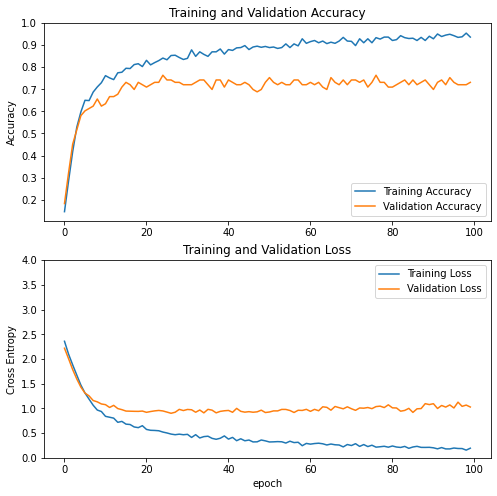

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,4])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Testing Model

Predict skin diseases image via upload file :

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
  path = '/content/' + fn
  images = image.load_img(path, target_size=(224,224,3))
  images = image.img_to_array(images)
  images = np.expand_dims(images, axis=0)

  classes = model.predict(images/255, batch_size=10)
  predd = np.argsort(-classes)
  print('\n=====================================')
  print('Predictive results of skin diseases :')
  print('=====================================')
  predd = [j for i in predd for j in i][:3]
  for pred in predd:
    if pred == 0:
      prob = classes[0][0] 
      print('Atopic dermatitis ({:.2%})'.format(prob))
    elif pred == 1:
      prob = classes[0][1]
      print('Cradle cap ({:.2%})'.format(prob))
    elif pred == 2:
      prob = classes[0][2]
      print('Diaper rash ({:.2%})'.format(prob))
    elif pred == 3:
      prob = classes[0][3]
      print('Drool rash ({:.2%})'.format(prob))
    elif pred == 4:
      prob = classes[0][4]
      print('HFMD ({:.2%})'.format(prob))
    elif pred == 5:
      prob = classes[0][5]
      print('Hemangioma ({:.2%})'.format(prob))
    elif pred == 6:
      prob = classes[0][6]
      print('Impetigo ({:.2%})'.format(prob))
    elif pred == 7:
      prob = classes[0][7]
      print('Miliria ({:.2%})'.format(prob))
    elif pred == 8:
      prob = classes[0][8]
      print('Pityriasis ({:.2%})'.format(prob))
    elif pred == 9:
      prob = classes[0][9]
      print('Rubeola ({:.2%})'.format(prob))
    elif pred == 10:
      prob = classes[0][10]
      print('Varicella ({:.2%})'.format(prob))

Saving tinea-versicolor-6-27.jpg to tinea-versicolor-6-27 (1).jpg

Predictive results of skin diseases :
Pityriasis (99.86%)
Atopic dermatitis (0.13%)
Miliria (0.00%)


## Model Evaluation

In [ ]:
test_dir = '/content/skin_dataset/test'

test2_datagen = ImageDataGenerator(rescale=1/255.0)

test_generator =  test2_datagen.flow_from_directory(test_dir,
                                                         target_size=(224,224),
                                                         shuffle = False,
                                                         class_mode = 'categorical')

Found 106 images belonging to 11 classes.


In [ ]:
test_labels = test_generator.classes
predictions = model.predict(x=test_generator, verbose=0)

Confusion matrix for testing data :

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, size=10)
    plt.yticks(tick_marks, classes, size=10)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


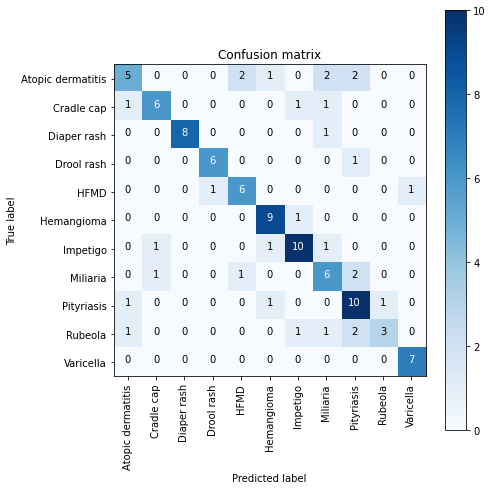

In [ ]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))
labels = ['Atopic dermatitis', 'Cradle cap', 'Diaper rash','Drool rash','HFMD', 'Hemangioma', 'Impetigo', 'Miliaria', 'Pityriasis', 'Rubeola', 'Varicella']
plot_confusion_matrix(cm, classes=labels)

## Save Model

Save model in format pb :

In [ ]:
SD_SAVED_MODEL = "skin_diseases"
tf.saved_model.save(model, SD_SAVED_MODEL)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: skin_diseases/assets


In [ ]:
%%bash -s $SD_SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['input_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: serving_default_input_1:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense_15'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 11)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [ ]:
loaded = tf.saved_model.load(SD_SAVED_MODEL)

print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'input_1': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1')})
{'dense_15': TensorSpec(shape=(None, 11), dtype=tf.float32, name='dense_15')}


## Convert Model into TF Lite and Post Training Quatization

In [ ]:
def representative_data_gen():
  dataset_list = tf.data.Dataset.list_files(test_dir + '/*/*')
  for i in range(99):
    image = next(iter(dataset_list))
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224,224))
    image = tf.cast(image / 255., tf.float32)
    image = tf.expand_dims(image, 0)
    yield [image]

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(SD_SAVED_MODEL)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model = converter.convert()
tflite_model_file = 'converted_model.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


## Download Model

Make txt file for skin diseases labels :

In [ ]:
with open('labels.txt', 'w') as f:
    f.write('\n'.join(labels))

Download model pb, tflite, and labels :

In [ ]:
!zip -r /content/skin_diseases.zip /content/skin_diseases

files.download('/content/skin_diseases.zip')
files.download('converted_model.tflite')
files.download('labels.txt')

  adding: content/skin_diseases/ (stored 0%)
  adding: content/skin_diseases/assets/ (stored 0%)
  adding: content/skin_diseases/saved_model.pb (deflated 92%)
  adding: content/skin_diseases/variables/ (stored 0%)
  adding: content/skin_diseases/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/skin_diseases/variables/variables.index (deflated 77%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>